<a href="https://colab.research.google.com/github/czarolag/Spotify-Review---Sentimental-Analysis/blob/main/notebook/Spotify_Review_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

## Our dataset
This colab explores a dataset filled with reviews on the popular music app Spotify. These reviews are either positive and negative. You can find more about the dataset from Kaggle [here](https://www.kaggle.com/datasets/alexandrakim2201/spotify-dataset).

&nbsp;
## Our task
The objective of our task is to create an model to predict whether a review is positive or negative based on the contents contained within the review. To complete this task we decided to implement a neural network. This model will be trained to have an acceptable accuracy rate to predict the proper type of review whether it describes the app in a positive manner or negative manner.

&nbsp;

Change runtime type to GPU if you want to run cells. Training times will take too long if running on CPU. To change run type, press the small arrow near `Connect` on the top right and press `Change runtime type` to `T4 GPU`. Also note you must run cells in order or errors may occur.

---

In [6]:
# @title ## Getting our necessary imports (run this cell) { display-mode: "form" }
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import seaborn as sns # for nicer plots
sns.set(style='darkgrid') # default style
import plotly.graph_objs as plotly  # for interactive plots

import string
import re

import tensorflow as tf
from google.colab import userdata
import os

## Dowloading our Dataset

### Kaggle API
Using the Kaggle API, we will download our dataset from Kaggle directly. This method requires a simple setup using the Google Colab 'Secrets' feature and obtaining a token from Kaggle.


Help on this setup was obtained from a discussion board on [Kaggle](https://www.kaggle.com/discussions/general/74235#2580958)

&nbsp;

If help is required on this setup, follow the kaggle link.


In [2]:
# Environmental variables must be set up for this method to work
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

!kaggle datasets download -d alexandrakim2201/spotify-dataset
!unzip -q 'spotify-dataset'

Dataset URL: https://www.kaggle.com/datasets/alexandrakim2201/spotify-dataset
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
  0% 0.00/2.90M [00:00<?, ?B/s]
100% 2.90M/2.90M [00:00<00:00, 1.13GB/s]


---

---
# Cleaning up and formatting our Dataset

We must gather all our reviews into a dataset and format it to preprocess our data. To begin, we will create a DataFrame that will keep track of the the reviews.

In [3]:
content_file = '/content/DATASET.csv'

df = pd.read_csv(content_file)
df.dropna(inplace=True)

display(df)

,Review,label
0,"Great music service, the audio is high quality...",POSITIVE
1,Please ignore previous negative rating. This a...,POSITIVE
2,"This pop-up ""Get the best Spotify experience o...",NEGATIVE
3,Really buggy and terrible to use as of recently,NEGATIVE
4,Dear Spotify why do I get songs that I didn't ...,NEGATIVE
...,...,...
52697,Yes the best,POSITIVE
52698,Spotify won my heart in Feb 2024 You won my he...,POSITIVE
52699,I tried to open the app and it wont open I res...,POSITIVE
52700,Good,POSITIVE


In [4]:
def label_to_num(s):
  if s.lower() == 'negative':
    return 0
  else:
    return 1

In [7]:
# Cleaning the text
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,
    remove links, remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

In [8]:
review_label = ['negative', 'positive']

# clean text and change labels to 0 or 1 (negative, positive)
df['label'] = df['label'].apply(label_to_num)
df['Review'] = df['Review'].apply(clean_text)


display(df)

,Review,label
0,great music service the audio is high quality ...,1
1,please ignore previous negative rating this ap...,1
2,this popup get the best spotify experience on ...,0
3,really buggy and terrible to use as of recently,0
4,dear spotify why do i get songs that i didnt p...,0
...,...,...
52697,yes the best,1
52698,spotify won my heart in feb you won my heart ...,1
52699,i tried to open the app and it wont open i res...,1
52700,good,1


In [9]:
X_features = df['Review']
Y_labels = df['label']

print('Shape of our X_features array:', X_features.shape)
print('Shape of our Y_labels array:', Y_labels.shape)

Shape of our X_features array: (52686,)
Shape of our Y_labels array: (52686,)


---
# Dataset Split

Now that we have set up and loaded our data, we must normalize our data and set an `80/20` split for `training/testing`. Once again, `X_train/X_test` will just be filled with our reviews as text and `Y_train/Y_test` will just be the labels to each review. `0` being a `negative review`, `1` being a `positive review`.

In [10]:
X_train, X_test = np.array_split(X_features, [int(len(df) * 0.8)])
Y_train, Y_test = np.array_split(Y_labels, [int(len(df) * 0.8)])

print('Shape of our X_train array:', X_train.shape)
print('Shape of our X_test array:', X_test.shape)

Shape of our X_train array: (42148,)
Shape of our X_test array: (10538,)


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


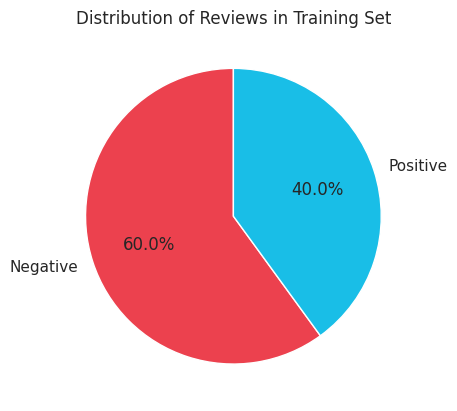

In [11]:
l = 'Negative', 'Positive'
sizes = [len(Y_train[Y_train == 0]), len(Y_train[Y_train == 1])]

fig, ax = plt.subplots()
ax.pie(sizes, labels=l, autopct='%1.1f%%', startangle=90, colors=['#ec414e', '#19bee7'])
plt.title('Distribution of Reviews in Training Set')

plt.show()

As you can see from the pie chart, our data is almost split 50/50 from our training set. 60% being negative reviews and the other 40% consisting of positive reviews. This means we have a sufficient amount of split to where we will encounter little to no bias when training. We will be checking for this in our baseline model.

---
# Visualizing our Data


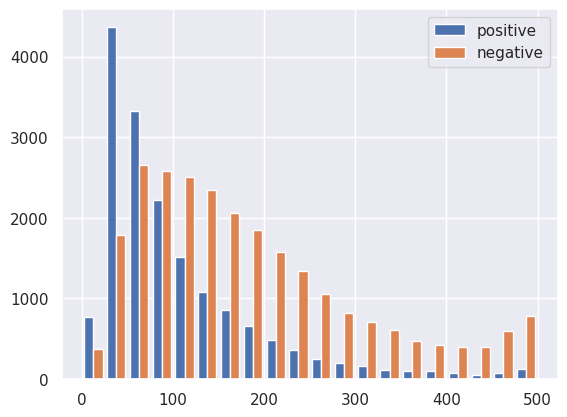

Longest positive review: 998
Longest negative review: 1623


In [12]:
# Create a list of lengths for training examples with a positive label.
text_lengths_pos = [len(x) for (i, x) in enumerate(X_train) if Y_train[i]]

# And a list of lengths for training examples with a negative label.
text_lengths_neg = [len(x) for (i, x) in enumerate(X_train) if not Y_train[i]]

# The histogram function can take a list of inputs and corresponding labels.
plt.hist([text_lengths_pos, text_lengths_neg], bins=20, range=(0, 500),
         label=['positive', 'negative'])
plt.legend()
plt.show()

# Also check the longest reviews.
print('Longest positive review:', max(text_lengths_pos))
print('Longest negative review:', max(text_lengths_neg))

# Tokenization

### Padding and Reduced Length
As is clear from the length histogram, the current representation of the review text is a variable-length array. Since fixed-length arrays are easier to work with in Tensorflow, let's add special padding tokens at the end of each review until they are all the same length.

We'll also use this operation to limit the number of token positions by truncating all reviews to a specified length. In the code below, as an example, we pad all training inputs to length 600.

&nbsp;

### Reduced Vocabulary
We also want to be able to limit the vocabulary size. Since our padding function produces fixed-length sequences in a numpy matrix, we can use clever numpy indexing to efficiently replace all token IDs larger than some value with the designated out-of-vocabulary (OOV) ID.

In the code below, as an example, we'll keep just token IDs less than 30000, replacing all others with OOV.

In [13]:
def preprocess_text_data(text_data, tokenizer, max_length, max_vocab_size):
    # Tokenize the text
    sequences = tokenizer.texts_to_sequences(text_data)

    # Pad sequences to a fixed length
    padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_length, padding='post', value=0)

    # Limit vocabulary to the max_vocab_size by setting any token_id >= max_vocab_size to 0 (OOV token)
    limited_vocab_sequences = np.where(padded_sequences >= max_vocab_size, 0, padded_sequences)

    return limited_vocab_sequences

In [14]:
# Initialize the tokenizer and fit on the data (X_train)
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=30000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Preprocess the training data
max_length = 600
max_vocab_size = 30000
X_train_processed = preprocess_text_data(X_train, tokenizer, max_length=max_length, max_vocab_size=max_vocab_size)


In [ ]:
X_train_processed[500]

array([9675,    4, 2318,   14,    7, 1399,   41,   86,   23,  339,  947,
         41,    4,  364,   37,    3,  133,   24,   11,   46,    5,    6,
        132,    8,  326,  189,   22,    3,  421,  267,   24,   11,   46,
         23,   27,  108,   21,    3,   19,    4,  133,   24,  380,    4,
         58,    2,   22,    3,   53,    4,   26,  535,   42,    3,  323,
          8,   22,    6,   80,   50,   26,    6,    3,   49,   50,   58,
          2,   22,    3,  497,   26,    3,   59,   58,  235,  469,  318,
          5,    2,  321,   68,  124,   43,    8, 9676, 2450,   52,  453,
         29,   14,    7,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

---
# Training Our Model

In [15]:
# Plot history of the model during training
def plot_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.legend()
  plt.show()

In [23]:
def build_deep_embeddings_model(vocab_size, sequence_length, embedding_dim):
    """Build a tf.keras model using embeddings."""
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    model = tf.keras.Sequential()

    # Embedding layer
    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        )
    )

    # Pooling and dense layers
    model.add(tf.keras.layers.GlobalAveragePooling1D())
    model.add(tf.keras.layers.Dense(units=8, activation='relu'))
    model.add(tf.keras.layers.Dense(units=16, activation='relu'))
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

# Build and summarize the model
model = build_deep_embeddings_model(
    vocab_size=max_vocab_size,
    sequence_length=X_train_processed.shape[1],
    embedding_dim=2
)

Epoch 1/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5978 - loss: 0.6761 - val_accuracy: 0.6235 - val_loss: 0.6485
Epoch 2/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6102 - loss: 0.6363 - val_accuracy: 0.7246 - val_loss: 0.5694
Epoch 3/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7405 - loss: 0.5448 - val_accuracy: 0.7730 - val_loss: 0.4993
Epoch 4/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7823 - loss: 0.4871 - val_accuracy: 0.8221 - val_loss: 0.4432
Epoch 5/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8147 - loss: 0.4378 - val_accuracy: 0.8482 - val_loss: 0.4068
Epoch 6/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8375 - loss: 0.3984 - val_accuracy: 0.8577 - val_loss: 0.3823
Epoch 7/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8514 - loss: 0.3723 - val_accuracy: 0.8614 - val_loss: 0.3689
Epoch 8/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8582 - loss: 0.3575 - val_accuracy: 0.

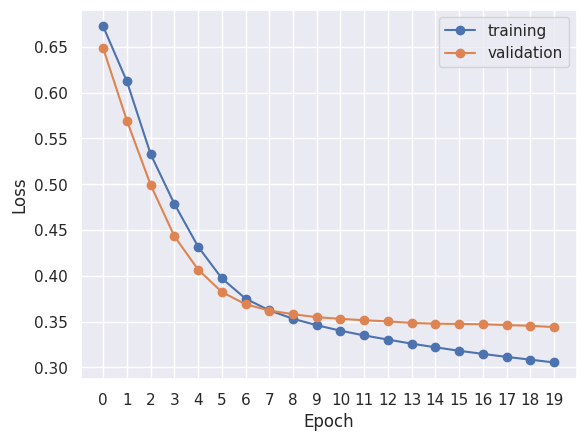

In [26]:
history = model.fit(
  x = X_train_processed,
  y = Y_train,
  epochs=20,
  batch_size=64,
  validation_split=0.1,
  verbose=1,
  )

history = pd.DataFrame(history.history)
plot_history(history)

In [27]:
# Display the model layers.
display(model.layers)

# Retrieve the embeddings layer, which itself is wrapped in a list.
embeddings = model.layers[0].get_weights()[0]
display(embeddings.shape)

[<Embedding name=embedding, built=True>,
 <GlobalAveragePooling1D name=global_average_pooling1d, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>,
 <Dense name=dense_2, built=True>]

(30000, 2)

In [28]:
def plot_2d_embeddings(embeddings, id_start=1, count=100):
  # Get 1st and 2nd embedding dims for the desired tokens.
  x1 = embeddings[id_start:id_start+count, 0]
  x2 = embeddings[id_start:id_start+count, 1]


  # Get the corresponding words from the reverse index (for labeling).
  tokens = tokenizer.index_word
  tokens = [tokens[i] for i in range(id_start, id_start+count)]

  # Plot with the plotly library.
  data = plotly.Scatter(x=x1, y=x2, text=tokens,
                        mode='markers', textposition='bottom left',
                        hoverinfo='text')
  fig = plotly.Figure(data=[data],
                      layout=plotly.Layout(title="Word Embeddings",
                                           hovermode='closest'))
  fig.show()

# Very frequent tokens tend to be more syntactic than semantic, so let's plot
# some rarer words.
plot_2d_embeddings(embeddings, id_start=500, count=500)

---
# Testing the Model

In [29]:
X_test_processed = preprocess_text_data(X_test, tokenizer, max_length=max_length, max_vocab_size=max_vocab_size)
model.evaluate(X_test_processed, Y_test)

330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8274 - loss: 0.3992


[0.5225487947463989, 0.7451128959655762]

# Demo

In [30]:
user_input = input("Enter a review: ")
user_input = clean_text(user_input)

user_prediction = model.predict(preprocess_text_data([user_input], tokenizer, max_length=max_length, max_vocab_size=max_vocab_size))
print('Review speaks negatively' if user_prediction[0][0] < 0.6 else 'Review is speaks positively')

Enter a review: This app doesn't have a lot of features.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Review speaks negatively


In [31]:
user_input = input("Enter a review: ")
user_input = clean_text(user_input)

user_prediction = model.predict(preprocess_text_data([user_input], tokenizer, max_length=max_length, max_vocab_size=max_vocab_size))
print('Review speaks negatively' if user_prediction[0][0] < 0.6 else 'Review is speaks positively')

Enter a review: I am in love with this app. Truly Unique!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Review is speaks positively
